In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split,StratifiedKFold
from statistics import mean, stdev
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score

from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout,Conv2D,MaxPooling2D,Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\jdeed\AppData\Local\Temp\ipykernel_19536\3005939997.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [3]:
def save_pickle(variable,filename,folder):
    pickle_out=open(str(folder)+"/"+str(filename) + ".pickle","wb")
    pickle.dump(variable,pickle_out)
    pickle_out.close()
    
def load_pickle(filename,folder):
    return pickle.load(open(str(folder)+"/"+str(filename) + ".pickle","rb"))

In [4]:
def normalized_training_test_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        shuffle=True,
                                                        random_state=random_state)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [5]:
def PCA_transform(X_train,X_test):
    pca = PCA(0.9,random_state=random_state)
    X1 = pca.fit_transform(X_train)
    X2 = pca.transform(X_test)
    return pd.DataFrame(X1), pd.DataFrame(X2)

In [6]:
def create_train_test_set(X,y,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=True, stratify=y,
                                                    random_state=n)
    return X_train,y_train,X_test,y_test

In [7]:
def build_mlp_model(hp):
    model = Sequential()
    
    model.add(InputLayer(input_shape=(X_dim,), name='Input_Layer'))
    model.add(Dropout(hp.Choice("Input_Dropout_layer",[0.5,0.6,0.7,0.8])))
    
    for i in range(3):
        model.add(Dense(hp.Int(f'Hidden_{i}_layer',32,512,32),activation='relu',name=f'Hidden_layer_{i}'))
        model.add(Dropout(hp.Choice(f'Dropout_{i}_layer',[0.5,0.6,0.7,0.8]),name=f'Dropou_layer_{i}'))
                  
    model.add(Dense(1, activation='sigmoid', name='Output_Layer'))
    
    opt=Adam(learning_rate=4e-5)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

In [8]:
def best_network_hyperparameter(model_builder,trials,filename):
    tuner = RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=trials,
        executions_per_trial=2,
        directory='project',
        project_name=filename)
    criterion=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    tuner_result = tuner.search(X_train, y_train,epochs=20,batch_size=16,validation_split=0.1,callbacks=[criterion])
    
    return tuner.get_best_hyperparameters()[0]

In [9]:
def network_fit(network_model,X_train,y_train):
    criterion = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    model_fit = network_model.fit(X_train, y_train, batch_size=16, epochs=200, verbose=2,
                      validation_split=0.1,callbacks=[criterion])
    return model_fit

In [10]:
def network_analysis(network_model,model_fit,X_test,y_test):
    test_loss, test_acc = network_model.evaluate(X_test, y_test)
    y_preds=pd.DataFrame(network_model.predict(X_test))
    fpr, tpr, _=roc_curve(y_test,y_preds)
    far,frr=fpr,1-tpr
    err=max(np.argwhere(np.diff(np.sign(far - frr))).flatten())
    x_points=np.linspace(0,1,num=len(far))
    
    print('Test accuracy:' + str(round(test_acc*100,2))+"%")
    print('Model fit and testing time:' + str(round(end - start,2))+"s")
    
    figure, axis = plt.subplots(2,2,figsize=(15,15))
    
    axis[0,0].plot(model_fit.history['loss'],'k',linewidth=3.0)
    axis[0,0].plot(model_fit.history['val_loss'],'b',linewidth=3.0)
    axis[0,0].legend(['Training loss', 'Validation Loss'],fontsize=12)
    axis[0,0].set_xlabel('Epochs ',fontsize=16)
    axis[0,0].set_ylabel('Loss',fontsize=16)
    axis[0,0].set_title('Loss Curves',fontsize=16)
    
    axis[0,1].plot(model_fit.history['accuracy'],'k',linewidth=3.0)
    axis[0,1].plot(model_fit.history['val_accuracy'],'b',linewidth=3.0)
    axis[0,1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    axis[0,1].set_xlabel('Epochs ',fontsize=16)
    axis[0,1].set_ylabel('Accuracy',fontsize=16)
    axis[0,1].set_title('Accuracy Curves',fontsize=16)
    
    axis[1,0].set_title("ROC Curve",fontsize=16)
    axis[1,0].plot(fpr,tpr,'b')
    axis[1,0].set_ylabel('TPR: True Positive Rate')
    axis[1,0].set_ylim(0, 1)
    axis[1,0].set_xlabel('FPR: False Positive Rate')
    axis[1,0].set_xlim(0, 1)
    
    axis[1,1].set_title("FRR FAR Curve",fontsize=16)
    axis[1,1].plot(x_points,far,'k',label ='FAR')
    axis[1,1].plot(x_points,frr,'b',label ='FRR')
    axis[1,1].scatter(x_points[err], far[err],s=100)
    axis[1,1].text(x_points[err]+0.05,far[err],"Equal Error Rate ~" +
               str(round(far[err],4)),fontsize = 10)
    axis[1,1].legend(loc ="center left")
    axis[1,1].set_ylabel('Error Rate')
    axis[1,1].set_ylim(0, 1)
    axis[1,1].axes.get_xaxis().set_visible(False)
    

    plt.show()

In [11]:
X_data=pickle.load(open("data/X.pickle","rb"))
y_data=pickle.load(open("data/y.pickle","rb"))
X_dim = np.prod(X_data.shape[1:])
X=X_data.reshape(X_data.shape[0],X_dim).astype("float64")/255
y=np.array(y_data)

In [12]:
X_train,y_train,X_test,y_test=create_train_test_set(X,y,42)

In [13]:
filename,folder="mlp_hyperparameter","project"
#mlp_hyperparameters=best_network_hyperparameter(build_mlp_model,100,filename)
#save_pickle(mlp_hyperparameters,filename,folder)

In [14]:
mlp_hyperparameters=load_pickle(filename,folder)
print(mlp_hyperparameters.values)

{'Input_Dropout_layer': 0.7, 'Hidden_0_layer': 384, 'Dropout_0_layer': 0.6, 'Hidden_1_layer': 320, 'Dropout_1_layer': 0.8, 'Hidden_2_layer': 448, 'Dropout_2_layer': 0.6}


In [15]:
mlp_model=build_mlp_model(mlp_hyperparameters)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 Hidden_layer_0 (Dense)      (None, 384)               3539328   
                                                                 
 Dropou_layer_0 (Dropout)    (None, 384)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 320)               123200    
                                                                 
 Dropou_layer_1 (Dropout)    (None, 320)               0         
                                                                 
 Hidden_layer_2 (Dense)      (None, 448)               143808    
                                                                 
 Dropou_layer_2 (Dropout)    (None, 448)               0

In [16]:
start = time.time()
mlp_fit=network_fit(mlp_model,X_train,y_train)
end = time.time()

Epoch 1/200
134/134 - 2s - loss: 0.9716 - accuracy: 0.5117 - val_loss: 0.6861 - val_accuracy: 0.5378 - 2s/epoch - 17ms/step
Epoch 2/200
134/134 - 1s - loss: 0.8134 - accuracy: 0.5126 - val_loss: 0.6829 - val_accuracy: 0.6261 - 794ms/epoch - 6ms/step
Epoch 3/200
134/134 - 1s - loss: 0.7488 - accuracy: 0.5313 - val_loss: 0.6762 - val_accuracy: 0.6218 - 791ms/epoch - 6ms/step
Epoch 4/200
134/134 - 1s - loss: 0.7107 - accuracy: 0.5566 - val_loss: 0.6721 - val_accuracy: 0.6387 - 800ms/epoch - 6ms/step
Epoch 5/200
134/134 - 1s - loss: 0.6849 - accuracy: 0.5842 - val_loss: 0.6640 - val_accuracy: 0.6765 - 795ms/epoch - 6ms/step
Epoch 6/200
134/134 - 1s - loss: 0.6595 - accuracy: 0.6123 - val_loss: 0.6494 - val_accuracy: 0.6849 - 884ms/epoch - 7ms/step
Epoch 7/200
134/134 - 1s - loss: 0.6294 - accuracy: 0.6384 - val_loss: 0.6396 - val_accuracy: 0.6807 - 882ms/epoch - 7ms/step
Epoch 8/200
134/134 - 1s - loss: 0.5941 - accuracy: 0.6941 - val_loss: 0.6249 - val_accuracy: 0.7101 - 1s/epoch - 7ms/st

Epoch 66/200
134/134 - 1s - loss: 0.0762 - accuracy: 0.9775 - val_loss: 0.6667 - val_accuracy: 0.7773 - 929ms/epoch - 7ms/step
Epoch 67/200
134/134 - 1s - loss: 0.0939 - accuracy: 0.9719 - val_loss: 0.5361 - val_accuracy: 0.7563 - 926ms/epoch - 7ms/step
Epoch 68/200
134/134 - 1s - loss: 0.0689 - accuracy: 0.9743 - val_loss: 0.5435 - val_accuracy: 0.7773 - 920ms/epoch - 7ms/step
Epoch 69/200
134/134 - 1s - loss: 0.0595 - accuracy: 0.9808 - val_loss: 0.6661 - val_accuracy: 0.7605 - 921ms/epoch - 7ms/step
Epoch 70/200
134/134 - 1s - loss: 0.0773 - accuracy: 0.9733 - val_loss: 0.5990 - val_accuracy: 0.7605 - 930ms/epoch - 7ms/step
Epoch 71/200
134/134 - 1s - loss: 0.0917 - accuracy: 0.9696 - val_loss: 0.5194 - val_accuracy: 0.7857 - 926ms/epoch - 7ms/step
Epoch 72/200
134/134 - 1s - loss: 0.0749 - accuracy: 0.9771 - val_loss: 0.5429 - val_accuracy: 0.7857 - 927ms/epoch - 7ms/step
Epoch 73/200
134/134 - 1s - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.6354 - val_accuracy: 0.7563 - 923ms/e

9/9 [==============================] - 0s 2ms/step
Test accuracy:76.14%
Model fit and testing time:84.23s


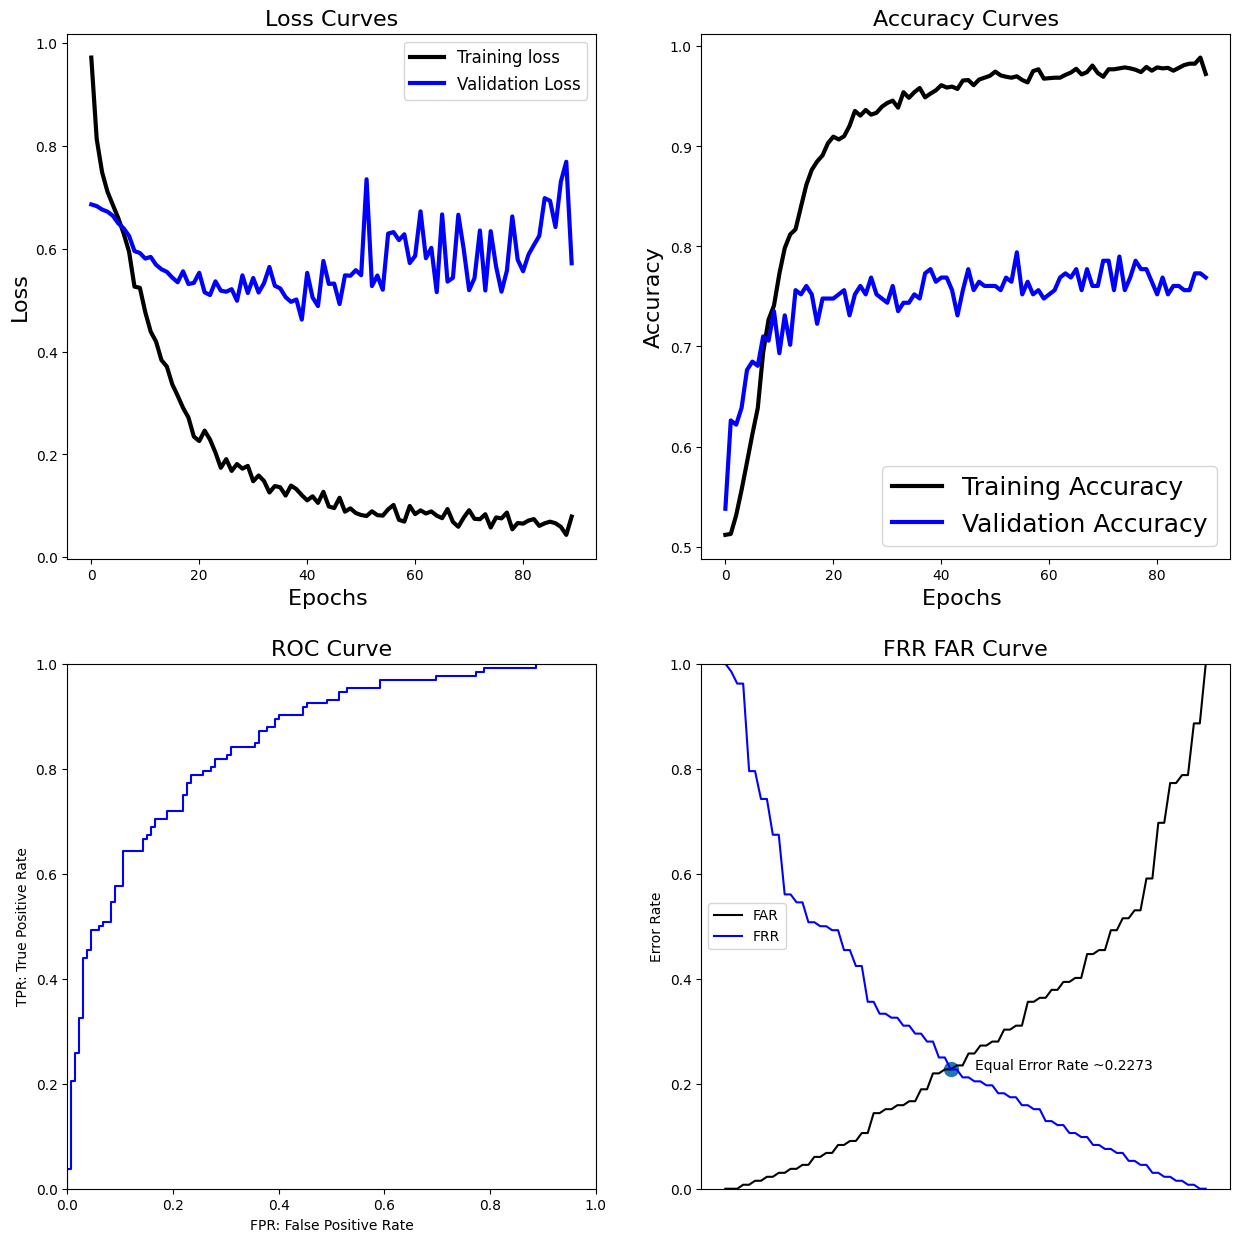

In [17]:
network_analysis(mlp_model,mlp_fit,X_test,y_test)

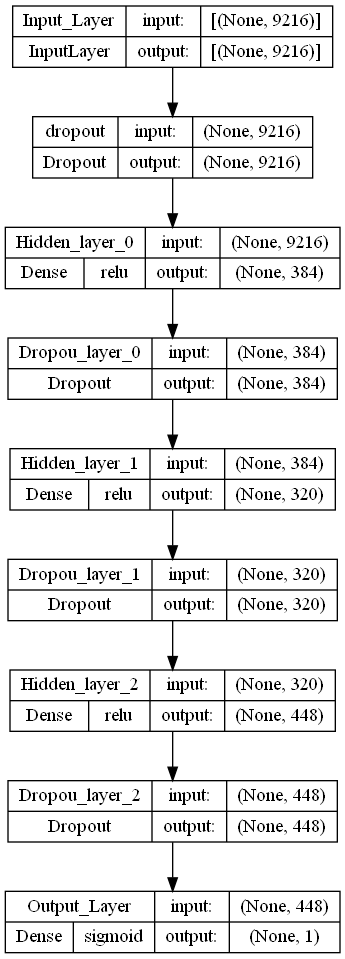

In [18]:
plot_model(mlp_model,dpi=96,show_shapes=True,show_layer_activations=True)

In [19]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=42,
                                       shuffle=True)

test_accuracy = []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mlp_model=build_mlp_model(mlp_hyperparameters)
    mlp_fit=network_fit(mlp_model,X_train,y_train)    
    test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
    test_accuracy.append(test_acc)

Epoch 1/200
119/119 - 2s - loss: 1.0502 - accuracy: 0.5016 - val_loss: 0.6830 - val_accuracy: 0.5519 - 2s/epoch - 14ms/step
Epoch 2/200
119/119 - 1s - loss: 0.8067 - accuracy: 0.5153 - val_loss: 0.6817 - val_accuracy: 0.5943 - 737ms/epoch - 6ms/step
Epoch 3/200
119/119 - 1s - loss: 0.7536 - accuracy: 0.5205 - val_loss: 0.6758 - val_accuracy: 0.5708 - 740ms/epoch - 6ms/step
Epoch 4/200
119/119 - 1s - loss: 0.7154 - accuracy: 0.5679 - val_loss: 0.6661 - val_accuracy: 0.6038 - 763ms/epoch - 6ms/step
Epoch 5/200
119/119 - 1s - loss: 0.6729 - accuracy: 0.6068 - val_loss: 0.6368 - val_accuracy: 0.7075 - 769ms/epoch - 6ms/step
Epoch 6/200
119/119 - 1s - loss: 0.6535 - accuracy: 0.6321 - val_loss: 0.6277 - val_accuracy: 0.7075 - 779ms/epoch - 7ms/step
Epoch 7/200
119/119 - 1s - loss: 0.5984 - accuracy: 0.6716 - val_loss: 0.6039 - val_accuracy: 0.7170 - 780ms/epoch - 7ms/step
Epoch 8/200
119/119 - 1s - loss: 0.5710 - accuracy: 0.7184 - val_loss: 0.5979 - val_accuracy: 0.7170 - 804ms/epoch - 7ms

Epoch 66/200
119/119 - 1s - loss: 0.0641 - accuracy: 0.9789 - val_loss: 0.5251 - val_accuracy: 0.7877 - 858ms/epoch - 7ms/step
Epoch 67/200
119/119 - 1s - loss: 0.0869 - accuracy: 0.9732 - val_loss: 0.5202 - val_accuracy: 0.7830 - 853ms/epoch - 7ms/step
Epoch 68/200
119/119 - 1s - loss: 0.0793 - accuracy: 0.9737 - val_loss: 0.4692 - val_accuracy: 0.8113 - 845ms/epoch - 7ms/step
Epoch 69/200
119/119 - 1s - loss: 0.0888 - accuracy: 0.9742 - val_loss: 0.4845 - val_accuracy: 0.7877 - 848ms/epoch - 7ms/step
Epoch 70/200
119/119 - 1s - loss: 0.0896 - accuracy: 0.9711 - val_loss: 0.4359 - val_accuracy: 0.8208 - 842ms/epoch - 7ms/step
Epoch 71/200
119/119 - 1s - loss: 0.0912 - accuracy: 0.9742 - val_loss: 0.4728 - val_accuracy: 0.7877 - 838ms/epoch - 7ms/step
Epoch 72/200
119/119 - 1s - loss: 0.0668 - accuracy: 0.9779 - val_loss: 0.5834 - val_accuracy: 0.7642 - 843ms/epoch - 7ms/step
Epoch 73/200
119/119 - 1s - loss: 0.0742 - accuracy: 0.9768 - val_loss: 0.4749 - val_accuracy: 0.7783 - 839ms/e

Epoch 34/200
119/119 - 1s - loss: 0.1236 - accuracy: 0.9616 - val_loss: 0.5106 - val_accuracy: 0.7358 - 819ms/epoch - 7ms/step
Epoch 35/200
119/119 - 1s - loss: 0.1239 - accuracy: 0.9574 - val_loss: 0.4978 - val_accuracy: 0.7358 - 813ms/epoch - 7ms/step
Epoch 36/200
119/119 - 1s - loss: 0.1349 - accuracy: 0.9516 - val_loss: 0.5275 - val_accuracy: 0.7311 - 816ms/epoch - 7ms/step
Epoch 37/200
119/119 - 1s - loss: 0.1410 - accuracy: 0.9489 - val_loss: 0.5340 - val_accuracy: 0.7123 - 814ms/epoch - 7ms/step
Epoch 38/200
119/119 - 1s - loss: 0.1156 - accuracy: 0.9537 - val_loss: 0.4880 - val_accuracy: 0.7264 - 812ms/epoch - 7ms/step
Epoch 39/200
119/119 - 1s - loss: 0.1058 - accuracy: 0.9611 - val_loss: 0.5154 - val_accuracy: 0.7217 - 819ms/epoch - 7ms/step
Epoch 40/200
119/119 - 1s - loss: 0.1251 - accuracy: 0.9568 - val_loss: 0.5070 - val_accuracy: 0.7170 - 815ms/epoch - 7ms/step
Epoch 41/200
119/119 - 1s - loss: 0.1146 - accuracy: 0.9589 - val_loss: 0.5026 - val_accuracy: 0.7264 - 818ms/e

Epoch 99/200
119/119 - 1s - loss: 0.0646 - accuracy: 0.9800 - val_loss: 0.4646 - val_accuracy: 0.8066 - 819ms/epoch - 7ms/step
Epoch 100/200
119/119 - 1s - loss: 0.0426 - accuracy: 0.9858 - val_loss: 0.5592 - val_accuracy: 0.8019 - 835ms/epoch - 7ms/step
Epoch 101/200
119/119 - 1s - loss: 0.0692 - accuracy: 0.9784 - val_loss: 0.5857 - val_accuracy: 0.7877 - 853ms/epoch - 7ms/step
Epoch 102/200
119/119 - 1s - loss: 0.0461 - accuracy: 0.9826 - val_loss: 0.6145 - val_accuracy: 0.7877 - 869ms/epoch - 7ms/step
Epoch 103/200
119/119 - 1s - loss: 0.0599 - accuracy: 0.9821 - val_loss: 0.6110 - val_accuracy: 0.8066 - 848ms/epoch - 7ms/step
Epoch 104/200
119/119 - 1s - loss: 0.0512 - accuracy: 0.9832 - val_loss: 0.6928 - val_accuracy: 0.8208 - 845ms/epoch - 7ms/step
Epoch 105/200
119/119 - 1s - loss: 0.0301 - accuracy: 0.9916 - val_loss: 0.6577 - val_accuracy: 0.8255 - 821ms/epoch - 7ms/step
Epoch 106/200
119/119 - 1s - loss: 0.0557 - accuracy: 0.9832 - val_loss: 0.6181 - val_accuracy: 0.8208 - 

Epoch 57/200
119/119 - 1s - loss: 0.0861 - accuracy: 0.9689 - val_loss: 0.5979 - val_accuracy: 0.7075 - 826ms/epoch - 7ms/step
Epoch 58/200
119/119 - 1s - loss: 0.1106 - accuracy: 0.9674 - val_loss: 0.4533 - val_accuracy: 0.7453 - 826ms/epoch - 7ms/step
Epoch 59/200
119/119 - 1s - loss: 0.0827 - accuracy: 0.9747 - val_loss: 0.5198 - val_accuracy: 0.7547 - 822ms/epoch - 7ms/step
Epoch 60/200
119/119 - 1s - loss: 0.0952 - accuracy: 0.9684 - val_loss: 0.4802 - val_accuracy: 0.7594 - 826ms/epoch - 7ms/step
Epoch 61/200
119/119 - 1s - loss: 0.0898 - accuracy: 0.9684 - val_loss: 0.4719 - val_accuracy: 0.7453 - 822ms/epoch - 7ms/step
Epoch 62/200
119/119 - 1s - loss: 0.0974 - accuracy: 0.9684 - val_loss: 0.5118 - val_accuracy: 0.7311 - 820ms/epoch - 7ms/step
Epoch 63/200
119/119 - 1s - loss: 0.0552 - accuracy: 0.9779 - val_loss: 0.5809 - val_accuracy: 0.7453 - 823ms/epoch - 7ms/step
Epoch 64/200
119/119 - 1s - loss: 0.0696 - accuracy: 0.9742 - val_loss: 0.5382 - val_accuracy: 0.7500 - 821ms/e

Epoch 13/200
119/119 - 1s - loss: 0.4026 - accuracy: 0.8168 - val_loss: 0.5575 - val_accuracy: 0.6887 - 816ms/epoch - 7ms/step
Epoch 14/200
119/119 - 1s - loss: 0.3576 - accuracy: 0.8411 - val_loss: 0.5753 - val_accuracy: 0.6651 - 842ms/epoch - 7ms/step
Epoch 15/200
119/119 - 1s - loss: 0.3423 - accuracy: 0.8442 - val_loss: 0.5707 - val_accuracy: 0.7075 - 861ms/epoch - 7ms/step
Epoch 16/200
119/119 - 1s - loss: 0.3119 - accuracy: 0.8711 - val_loss: 0.5670 - val_accuracy: 0.6840 - 847ms/epoch - 7ms/step
Epoch 17/200
119/119 - 1s - loss: 0.2792 - accuracy: 0.8837 - val_loss: 0.5679 - val_accuracy: 0.6934 - 870ms/epoch - 7ms/step
Epoch 18/200
119/119 - 1s - loss: 0.2562 - accuracy: 0.8979 - val_loss: 0.5753 - val_accuracy: 0.6934 - 850ms/epoch - 7ms/step
Epoch 19/200
119/119 - 1s - loss: 0.2476 - accuracy: 0.9032 - val_loss: 0.5792 - val_accuracy: 0.6651 - 821ms/epoch - 7ms/step
Epoch 20/200
119/119 - 1s - loss: 0.2578 - accuracy: 0.8947 - val_loss: 0.5604 - val_accuracy: 0.6887 - 831ms/e

Epoch 4/200
119/119 - 1s - loss: 0.7300 - accuracy: 0.5374 - val_loss: 0.6759 - val_accuracy: 0.6226 - 844ms/epoch - 7ms/step
Epoch 5/200
119/119 - 1s - loss: 0.7136 - accuracy: 0.5468 - val_loss: 0.6687 - val_accuracy: 0.6179 - 833ms/epoch - 7ms/step
Epoch 6/200
119/119 - 1s - loss: 0.6739 - accuracy: 0.6032 - val_loss: 0.6612 - val_accuracy: 0.5802 - 823ms/epoch - 7ms/step
Epoch 7/200
119/119 - 1s - loss: 0.6321 - accuracy: 0.6347 - val_loss: 0.6286 - val_accuracy: 0.6698 - 832ms/epoch - 7ms/step
Epoch 8/200
119/119 - 1s - loss: 0.6370 - accuracy: 0.6526 - val_loss: 0.6207 - val_accuracy: 0.6651 - 833ms/epoch - 7ms/step
Epoch 9/200
119/119 - 1s - loss: 0.5673 - accuracy: 0.7163 - val_loss: 0.5891 - val_accuracy: 0.6934 - 828ms/epoch - 7ms/step
Epoch 10/200
119/119 - 1s - loss: 0.5354 - accuracy: 0.7321 - val_loss: 0.5995 - val_accuracy: 0.7028 - 822ms/epoch - 7ms/step
Epoch 11/200
119/119 - 1s - loss: 0.5240 - accuracy: 0.7274 - val_loss: 0.5910 - val_accuracy: 0.7028 - 824ms/epoch -

Epoch 69/200
119/119 - 1s - loss: 0.0711 - accuracy: 0.9758 - val_loss: 0.5814 - val_accuracy: 0.7736 - 817ms/epoch - 7ms/step
Epoch 70/200
119/119 - 1s - loss: 0.0769 - accuracy: 0.9805 - val_loss: 0.5449 - val_accuracy: 0.7453 - 815ms/epoch - 7ms/step
Epoch 71/200
119/119 - 1s - loss: 0.0877 - accuracy: 0.9726 - val_loss: 0.5291 - val_accuracy: 0.7406 - 816ms/epoch - 7ms/step
Epoch 72/200
119/119 - 1s - loss: 0.0583 - accuracy: 0.9800 - val_loss: 0.5771 - val_accuracy: 0.7547 - 816ms/epoch - 7ms/step
Epoch 73/200
119/119 - 1s - loss: 0.0536 - accuracy: 0.9842 - val_loss: 0.6295 - val_accuracy: 0.7642 - 809ms/epoch - 7ms/step
Epoch 74/200
119/119 - 1s - loss: 0.0919 - accuracy: 0.9758 - val_loss: 0.5872 - val_accuracy: 0.7642 - 820ms/epoch - 7ms/step
Epoch 75/200
119/119 - 1s - loss: 0.0589 - accuracy: 0.9832 - val_loss: 0.5664 - val_accuracy: 0.7453 - 825ms/epoch - 7ms/step
Epoch 76/200
119/119 - 1s - loss: 0.0674 - accuracy: 0.9811 - val_loss: 0.5268 - val_accuracy: 0.7642 - 822ms/e

In [20]:
print('List of possible accuracy:', test_accuracy)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(test_accuracy)*100, '%')
print('\nMinimum Accuracy:',
      min(test_accuracy)*100, '%')
print('\nOverall Accuracy:',
      mean(test_accuracy)*100, '%')
print('\nStandard Deviation is:', stdev(test_accuracy))

List of possible accuracy: [0.7765151262283325, 0.7973484992980957, 0.7405303120613098, 0.7537878751754761, 0.7878788113594055]

Maximum Accuracy That can be obtained from this model is: 79.73484992980957 %

Minimum Accuracy: 74.05303120613098 %

Overall Accuracy: 77.12121248245239 %

Standard Deviation is: 0.023632543477336745
